# Project 4D: West Nile Virus presence analysis

### Overall Contents:
- Background
- Data Cleaning
- Exploratory Data Analysis
- Modeling 1 Logistic Regression
- [Modeling 2 k-Nearest Neighbours](#5.-Modeling-2-k-Nearest-Neighbours) **(In this notebook)**
- Modeling 3 Random Forest
- Evaluation
- Conclusion and Recommendation

## 5. Modeling 2 k-Nearest Neighbours

### 5.1 Libraries Import

In [17]:
#!pip install imbalanced-learn

In [39]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, plot_roc_curve


%config InlineBackend.figure_format = 'retina'
%matplotlib inline 
# Maximum display of columns
pd.options.display.max_colwidth = 400
pd.options.display.max_rows = 400

### 5.2 Data Import

In [19]:
# Import data of train, weather, spray and test from csv
train_df = pd.read_csv('../data/train_df_model.csv')
test_df = pd.read_csv("../data/test_df_model.csv")

In [20]:
X = train_df.set_index('date').drop(['wnvpresent','latitude','longitude'], axis = 1)
y = train_df.wnvpresent
Z = test_df.set_index('date').drop(['latitude','longitude'], axis = 1)

### 5.3 Balance Class and train-test split

As there is a significant imbalance of classes, we will be using the SMOTE to balance the classes.

In [21]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE()
X_sm, y_sm = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=.25, random_state=42, stratify= y_sm)

In [22]:
y_train.value_counts(normalize = True)

1    0.5
0    0.5
Name: wnvpresent, dtype: float64

### 5.4 KNN modeling

In [23]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)
Z_sc = ss.transform(Z)


pipe_knn_params = {
    'knn__n_neighbors': [5,10,15,20,30,40],
    'knn__weights' : ['distance','uniform'],
    'knn__p' : [1,2]
}

#set up pipeline KNeighborsClassifier
pipe_knn = Pipeline([
    ('knn', KNeighborsClassifier())])

gs_knn = GridSearchCV(pipe_knn, 
                  param_grid=pipe_knn_params, 
                  cv = 5 , n_jobs = -1)
gs_knn.fit(X_train_sc, y_train)

print(f'Best Score : {gs_knn.best_score_}')
print(f'Train Score : {gs_knn.score(X_train_sc, y_train)}')
print(f'Test Score : {gs_knn.score(X_test_sc, y_test)}')

gs_results = pd.DataFrame(gs_knn.cv_results_)
gs_results = gs_results.sort_values(by=['mean_test_score'], ascending = False)
gs_results.rename(columns = {'param_knn__n_neighbors': 'n_neighbors',
                                     'param_knn__p': 'p',
                                     'param_knn__weights': 'weights',
                                     'mean_test_score': 'mean_score'                           
                                    }, inplace = True)
gs_results[['n_neighbors', 'p','weights','mean_score']].head(15)

Best Score : 0.9472945164702324
Train Score : 0.9813822662737745
Test Score : 0.9523905182804339


,n_neighbors,p,weights,mean_score
2,5,2,distance,0.947295
14,20,2,distance,0.947093
6,10,2,distance,0.946558
18,30,2,distance,0.945888
10,15,2,distance,0.945620
22,40,2,distance,0.944481
3,5,2,uniform,0.943410
7,10,2,uniform,0.932896
0,5,1,distance,0.928342
4,10,1,distance,0.918096


From our gridsearch parameters we were able to found out that the best parameters for using KNN model

In [34]:
gs_knn.best_params_

{'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}

In [28]:
y_pred = gs_knn.predict(X_test_sc)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2489
           1       0.95      0.96      0.95      2489

    accuracy                           0.95      4978
   macro avg       0.95      0.95      0.95      4978
weighted avg       0.95      0.95      0.95      4978



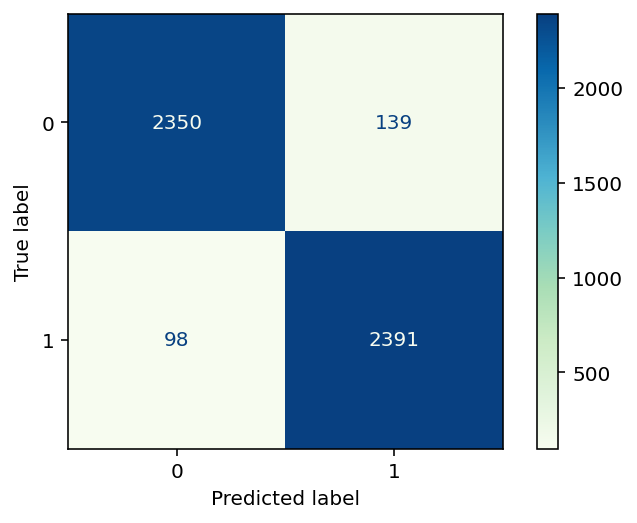

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
plot_confusion_matrix(gs_knn, X_test_sc, y_test, cmap='GnBu')

The results we got back was just slightly worse than the train score in terms of accuracy. However what we are concerned with is the recall score. Our recall scores of 94% and 95% for negative and positive shows that we have a large degree of correctly classifying the virus correctly. 

In [48]:
pred_df= pd.DataFrame({'true_values': y_test,
                        'pred_probs': gs_knn.predict_proba(X_test_sc)[:,1]})

C:\Users\Thomas\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


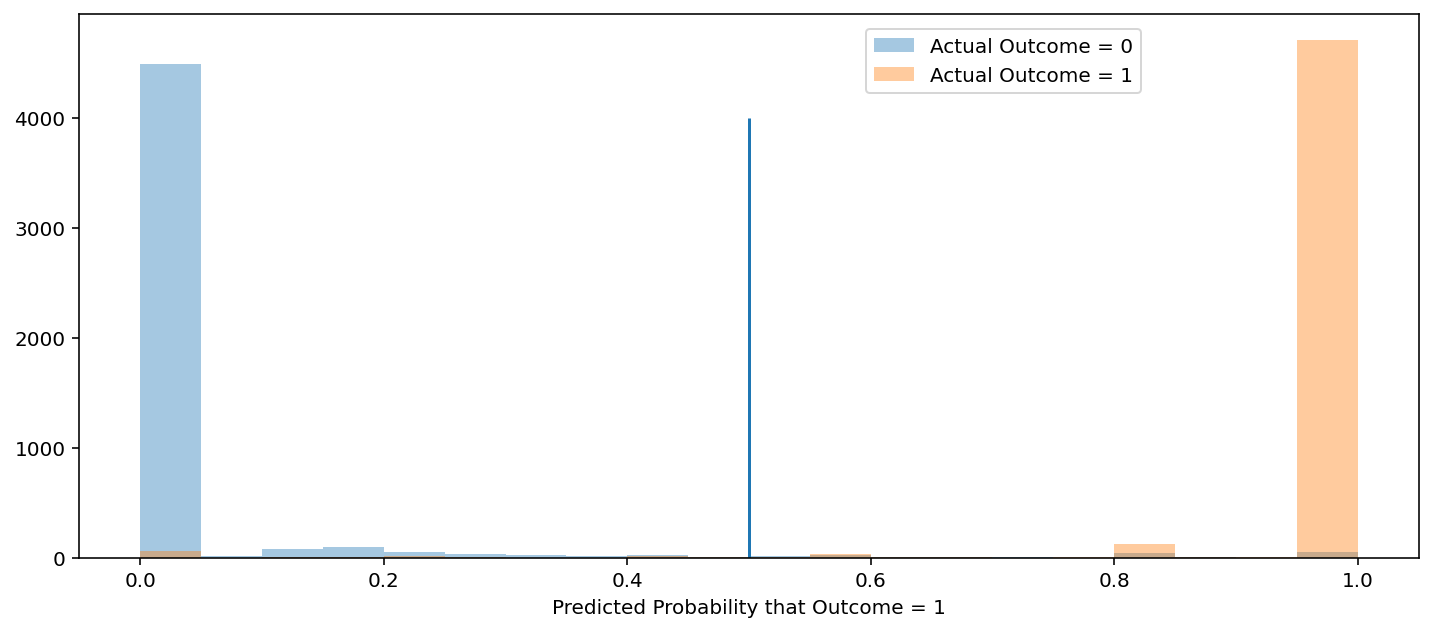

In [49]:
plt.figure(figsize = (12, 5))

# Plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Plot the cutoff line
plt.vlines(x = 0.5, ymin = 0, ymax = 4000)

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend(loc='best', bbox_to_anchor=(0.8,0.99));

plt.savefig(fname='../imgs/knn_pred_distribution.png')

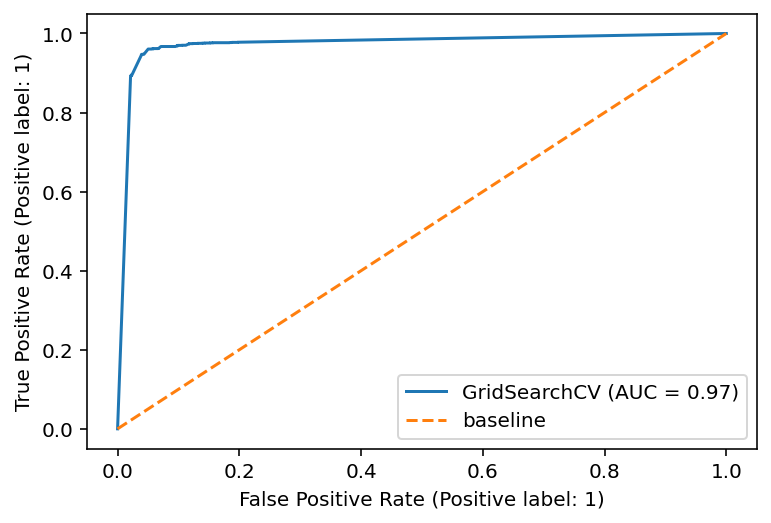

In [41]:
plot_roc_curve(gs_knn, X_test_sc, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

With an AUC value of 0.97, it could mean that our model is able to achieve a accuracy of 97% which is higher than the base of 50% from our dataset.

In [12]:
#pred = gs_knn.predict_proba(Z_sc)

In [13]:
#results = pd.DataFrame(pred,columns=['NotPresent','WnvPresent'])

In [14]:
#test = pd.read_csv("../data/test.csv")

In [15]:
#results = pd.concat([test['Id'],results], axis =1)
#results.to_csv("../data/knn_model.csv", index = False)

### 5.6. Summary

When using this model we balanced the class using SMOTE method. Allowing us to model with a balance distribution of 50% in each class. If this was not done we would have only been able to accuratly determine the class in one or the other class. 

With the inital baseline of 95% our model was able to achieve a 97% as shown in the AUC. The avg F1score of 95% was also an significant result.